In [ ]:
!pip install torch torch_geometric transformers tokenizers

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/co-citation-prediction/src

Mounted at /content/drive
/content/drive/MyDrive/co-citation-prediction/src


In [3]:
import torch
from tokenizers import Tokenizer
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

from data import EncoderDataset, GraphDataset, RegressionDataset
from encoder import EncoderModel
from graph import GraphModel
from model import Model
from regression import RegressionModel

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (torch.cuda.is_available())

True


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
embeddings = None
test = None
gc.collect()
torch.cuda.empty_cache()

In [ ]:
data_path = "../data/dataset.feather"
tokenizer_name = "sentence-transformers/all-MiniLM-L6-v2"
encoder_dataset = EncoderDataset(data_path, tokenizer_name, device)
encoder_loader = DataLoader(
    encoder_dataset,
    batch_size=24,
    shuffle=False,
    collate_fn=encoder_dataset.collate_fn
)

In [ ]:
encoder_config = {
  # "architectures": [
  #   "BertForMaskedLM"
  # ],
  # "attention_probs_dropout_prob": 0.1,
  # "gradient_checkpointing": False,
  # "hidden_act": "gelu",
  # "hidden_dropout_prob": 0.1,
  # "hidden_size": 768,
  # "initializer_range": 0.02,
  # "intermediate_size": 3072,
  # "layer_norm_eps": 1e-12,
  # "max_position_embeddings": 512,
  # "model_type": "bert",
  # "num_attention_heads": 12,
  # "num_hidden_layers": 12,
  # "pad_token_id": 0,
  # "position_embedding_type": "absolute",
  # "transformers_version": "4.6.0.dev0",
  # "type_vocab_size": 2,
  # "use_cache": True,
  # "vocab_size": 30522
  "_name_or_path": "nreimers/MiniLM-L6-H384-uncased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": False,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size": 2,
  "use_cache": True,
  "vocab_size": 30522
}
encoder_model_name = "sentence-transformers/all-MiniLM-L6-v2"
encoder_model = EncoderModel(encoder_model_name, encoder_config).to(device)

In [ ]:
count = 0
embeddings = np.empty((0, 384))
import time
for batch in encoder_loader:
  # print(count)
  # time.sleep(0.1)
  batch = batch[0]
  # print(batch.size())
  infer = encoder_model(batch)
  # print(infer)
  embed = infer[0].to('cpu')
  pool = infer[1].to('cpu')
  # print(embed[:, 0, :].size())
  add = embed[:, 0, :].cpu().tolist()
  # test.append(embed[:, 0, :].cpu().tolist())
  embeddings = np.concatenate((embeddings, add))
  # print(test.get_device())
  # embed_inpt = embed['last_hidden_state'][:, 0, :].cpu()
  # test = torch.cat((test, embed[:, 0, :]), dim=0)
  # test.append(embed_inpt)
  # embed = None
  # gc.collect()
  torch.cuda.empty_cache()
  # if count == 1:
  #   break
  # count += 1

/content/drive/MyDrive/co-citation-prediction/src/data.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tokens["input_ids"]).to(self.device), torch.tensor(tokens["attention_mask"]).to(self.device)


(100000, 384)

In [ ]:
embeddings.shape

(174103, 384)

In [ ]:
graph_dataset = GraphDataset(embeddings, encoder_dataset.data)
graph_loader = DataLoader(graph_dataset, shuffle=False)

In [ ]:
import pandas as pd
from itertools import combinations
from torch_geometric.data import Dataset as GeoDataset
from torch_geometric.data import Data as GeoData
from torch.nn.utils.rnn import pad_sequence

In [ ]:
edge_index = encoder_dataset.data[["id", "references"]].explode("references").values.transpose()
# lookupTable, indexed_dataSet = np.unique(edge_index.flatten(), return_inverse=True)

In [ ]:
paper_to_id = {}
id_to_paper = {}
graph_ei = np.empty(edge_index.shape)
curr_id = 0
for i in range(edge_index.shape[0]):
  for j in range(edge_index.shape[1]):
    papers = paper_to_id.keys()
    paper = edge_index[i, j]
    if paper not in papers:
      paper_to_id[paper] = curr_id
      id_to_paper[curr_id] = paper
      curr_id += 1
    graph_ei[i, j] = paper_to_id[paper]

In [ ]:
graph_ei

array([[     0.,      0.,      0., ...,  99999.,  99999.,  99999.],
       [ 57660., 100000., 100001., ..., 404534., 191684., 537998.]])

In [ ]:
remaining_papers = max(id_to_paper.keys()) - embeddings.shape[0] + 1
average_embed = np.mean(embeddings, axis=0, keepdims=True)
remaining_papers_embed = np.repeat(average_embed, remaining_papers, axis=0)
final_embed = np.concatenate((embeddings, remaining_papers_embed), axis=0)

In [ ]:
final_embed.shape

(538001, 384)

In [ ]:
final_embed = torch.tensor(final_embed)
graph_ei = torch.tensor(graph_ei, dtype=torch.int64)

In [ ]:
data = GeoData(x=final_embed, edge_index=graph_ei, is_directed=True)

In [ ]:
data.train_mask = None
data.val_mask = None
data.train_y = None
data.val_y = None

In [ ]:
data

Data(x=[538001, 384], edge_index=[2, 1108062], is_directed=True)

In [ ]:
regression_dataset = RegressionDataset(encoder_dataset.data)
regression_loader = DataLoader(regression_dataset, shuffle=False)

co_cite_count 10517324
co_cite_yearly 56
examples 142618


In [ ]:
co_cite_val = regression_dataset.examples

In [ ]:
pairs = torch.empty((0,2))
pair_y = torch.empty((0,))
for co_cite in co_cite_val:
  id_1, id_2 = co_cite[0]
  val = co_cite[1]
  graph_id_1 = paper_to_id[id_1]
  graph_id_2 = paper_to_id[id_2]
  # print(type(graph_id_1))
  pairs = torch.cat((pairs, torch.tensor([[graph_id_1, graph_id_2]], dtype=torch.int32)), dim=0)
  pair_y = torch.cat((pair_y, torch.tensor([val])))

  

In [ ]:
pairs = torch.tensor(pairs, dtype=torch.int64)
pair_y = torch.tensor(pair_y, dtype=torch.float)

<ipython-input-18-96202256d2b9>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pairs = torch.tensor(pairs, dtype=torch.int64)
<ipython-input-18-96202256d2b9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pair_y = torch.tensor(pair_y, dtype=torch.float)


In [ ]:
pairs

In [ ]:
torch.manual_seed(42)
train_p, val_p = 0.8, 0.2
# Step 1: Find a random permutation order of the links using torch.randperm
# Step 2: Assign the first 60% (rounded down) of the links as the training set (data.train_mask), next 10% (rounded down) as the validation (data.val_mask), 
#         and the remaining as the test (data.test_mask). 
# Step 3: Create new variables data.train_y, data.val_y, data.test_y storing all ones vector corresponding to the number of links in the corresponding set.
#         Make sure to put them on the memory of the `device` (default will be cpu but we want everything to be on GPU). 
## write your code below [0.5 points] ## 
N = pairs.size()[0]
rand = torch.randperm(N)
rand_cocites = pairs[rand, :]
rand_true_val = pair_y[rand]

train_mark = int(train_p * N)
data.train_mask = rand_cocites[:train_mark, :]
data.val_mask = rand_cocites[train_mark:, :]

data.train_y = rand_true_val[:train_mark]
data.val_y = rand_true_val[train_mark:]
#########################################

In [ ]:
count_1 = 0
count_2 = 0
for val in data.train_y:
  if val == -1:
    count_1 += 1
  else:
    count_2 += 1
print(count_1)
print(count_2) 

In [ ]:
data

Data(x=[538001, 384], edge_index=[2, 1108062], is_directed=True, train_mask=[114094, 2], val_mask=[28524, 2], train_y=[114094], val_y=[28524])

In [ ]:
torch.save(data, '../data/total_data.pt')

In [5]:
data = torch.load('../data/total_data.pt')

In [6]:
import torch
import torch.nn.functional as F
from torch.nn import Linear

class LPModel (torch.nn.Module):
    def __init__(self, dataset, hidden_channels=16):
        super().__init__()
        self.emb = torch.nn.Parameter(torch.rand(dataset.x.size()[0], hidden_channels).to(device))
        # self.emb = 0
        self.dec = None
        # Define the decoder (self.dec) as a single Linear layer that transforms an input of dimension 2*hidden_channels to an output of dimension 1. 
        ## write your code below [0.1 points] ##
        self.dec1 = Linear(2*hidden_channels, 32)
        self.act = torch.nn.ReLU()
        self.dec2 = Linear(32, 1)
        #########################################
    
    def forward (self, data):
        # Returns the embeddings of all nodes
        return self.emb

    def predict_proba (self, data, node_pairs):
        prob = None
        # Predict probabilities of link existence between the node_pairs (of dimension (num_node_pairs, 2))
        # Step 1: Call the forward function to obtain the embeddings from the data.
        # Step 2: Obtain the node embeddings for source and destination nodes from the node_pairs array and concatenate them together. 
        # Step 3: Pass the concatenated embeddings (of size 2*hidden_channels) through the decoder to obtain the logits for each node pair in node_pairs. 
        # Step 4: Use sigmoid activation torch.sigmoid() to obtain the probabilities between 0 and 1.
        # Step 5: Squeeze the values so that the output is (num_node_pairs,)
        ## write your code below [0.6 points] ##
        node_emb = self.forward(data)
        # prob = []
        # for node_pair in node_pairs:
        src = node_emb[node_pairs[:, 0]]
        dest = node_emb[node_pairs[:, 1]]
        inpt = torch.cat((src, dest), dim=1)
        out_1 = self.dec1(inpt)
        act_1 = self.act(out_1)
        out_2 = self.dec2(act_1)
        # act_1 = torch.sigmoid(out_1)
        pred = out_2.squeeze()
        #########################################
        return pred

    def predict (self, data, node_pairs):
        pred = None
        # Step 1: Predict the probabilities of link existence between the node_pairs using the predict_proba method
        # Step 2: Obtain the predicted label as 1 if probability is greater than 0.5 and 0 otherwise.
        ### write your code below [0.2 points] ##
        prob = self.predict_proba(data, node_pairs)
        pred = torch.round(prob)
        #########################################
        return pred

In [ ]:
!pip install pytorch_forecasting

In [23]:
criterion = None
from pytorch_forecasting.metrics.quantile import QuantileLoss
### write your code below [0.1 points] ##
# Initialize loss criterion as the binary cross entropy loss function
from torch.nn import MSELoss
# criterion = MSELoss()
# clss = Quantileloss()
criterion = QuantileLoss().loss
#########################################

In [27]:
def train_lp (model, data, criterion, optimizer, neg_weight=1, batch_size=4096):
    model.train()
    train_pos_loss, train_neg_loss = None, None
    # Step 1: Extract the link existence probability of only the positive (i.e., existing) training links using predict_proba 
    #          (you can use data.train_mask to obtain the positive training links and data.train_y to filter). 
    # Step 2: Compute the criterion loss between predicted probabilities and the actual labels of the positive 
    #           training links and store it in train_pos_loss
    # Step 3: Similarly, extract the link existence probability of only the negative (i.e., non-existing) training links using predict_proba 
    #          (you can use data.train_mask to obtain the negative training links and data.train_y to filter). 
    # Step 4: Compute the criterion loss between predicted probabilities and the actual labels of the negative 
    #           training links and store it in train_neg_loss
    # Step 5: Compute the gradients of the training loss (train_pos_loss + neg_weight*train_neg_loss) with respect to each parameter using the backward() call.
    # Step 6: Update the model parameters using the optimizer step() call.
    # Make sure to return a detached cpu tensor
    ### write your code below [0.5 points] ##
    # half = int(data.train_y.size()[0] / 2)
    import math 
    iter = math.ceil(data.train_y.size()[0] / batch_size)
    total_train_loss = 0 
    for i in range(iter):
      start = i*batch_size
      end = (i+1) * batch_size
      if i == iter - 1:
        end = data.train_y.size()[0]
      pred_y = model.predict_proba(data, data.train_mask[start:end])
      # print(pred_y.size())
      print(pred_y)
      print(data.train_y[start:end])
      train_loss = criterion(pred_y.cpu(), data.train_y[start:end].cpu())
      # train_loss = train_loss.double()
      train_loss.backward()
      total_train_loss += train_loss
      optimizer.step()
      optimizer.zero_grad()


    #########################################
    return total_train_loss.detach().cpu()

In [25]:
def validate_lp (model, data, criterion, neg_weight=1):
    model.eval()
    val_loss = None
    with torch.no_grad():
        # Step 1: Extract the link existence probability of only the positive (i.e., existing) links in the validation set using predict_proba 
        #          (you can use data.train_mask to obtain the positive training links and data.train_y to filter).
        # Step 2: Compute the criterion loss between predicted probabilities and the actual labels of the positive links in the validation set
        #          and store it in val_pos_loss
        # Step 3: Extract the link existence probability of only the negative (i.e., existing) links in the validation set using predict_proba 
        #          (you can use data.train_mask to obtain the negative training links and data.train_y to filter).
        # Step 4: Compute the criterion loss between predicted probabilities and the actual labels of the negative links in the validation set
        #          and store it in val_neg_loss
        # Step 5: Find val_loss as val_pos_loss + neg_weight * val_neg_loss.
        # Make sure to return a CPU tensor.
        ### write your code below [0.3 points] ##
        pred_y = model.predict_proba(data, data.val_mask)
        val_loss = criterion(pred_y.cpu(), data.val_y.cpu())
        #########################################
    return val_loss.cpu()

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# Note: You will be using the GCNConv to implement a graph convolution layer
from torch_geometric.nn import GCNConv 
from torch_geometric.nn import SAGEConv

# Implement a GCN model with 2 GCNConv layers with ReLU non-linearity and dropout

# This is similar to the above GCN definition.
class GCN(LPModel):
    def __init__(self, dataset, hidden_channels, dropout_probability):
        super(GCN, self).__init__(dataset, hidden_channels)
        self.dataset = dataset
        self.conv1 = None
        self.conv2 = None
        self.dropout_p = dropout_probability

        # Implement a GCN model with 2 GCNConv layers with ReLU non-linearity and dropout
        # Step 1: Define the first convolutional layer (self.conv1) with input as the node features and output = hidden dimension size
        # Step 2: Define the second convolution layer (self.conv2) with input as hidden dimension size and output would be number of classes in the dataset
        
        ### write your code below [0.1 points] ##
        data = dataset
        features = data.x.size()[1]
        # self.conv1 = GCNConv(features, hidden_channels, bias=True)
        # self.conv2 = GCNConv(hidden_channels, hidden_channels, bias=True)

        self.conv1 = SAGEConv(features, hidden_channels, bias=True, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, bias=True, aggr='mean')
        self.conv3 = SAGEConv(hidden_channels, hidden_channels, bias=True, aggr='mean')

        from torch.nn import ReLU, Dropout
        self.act = ReLU()
        self.drop = Dropout(p=dropout_probability)
        #########################################

    def forward(self, data):
        out = None

        # Step 1: Using the node features and the edge_index, compute intermediate representation via the first GCNConv layer
        # Step 2: Apply the ReLU non-linearity on the output of self.conv1
        # Step 3: Apply dropout
        # Step 4: Pass the output of step 3 through the second convolutional layer to get output embeddings 

        ### write your code below [0.2 points] ##
        feat = data.x.float()
        out_1 = self.conv1(feat, data.edge_index)
        act_1 = self.act(out_1)
        drop_1 = self.drop(act_1)
        out_2 = self.conv2(drop_1, data.edge_index)
        # act_2 = self.act(out_2)
        # out_3 = self.conv3(act_2, data.edge_index)
        out = F.log_softmax(out_2, dim=1)
        #########################################

        return out

In [15]:
# Hyperparameters of the model. DO NOT CHANGE.
hidden_channels = 16
dropout_probability = 0.15
data.to(device)
gcn_model = GCN(data, hidden_channels=hidden_channels, dropout_probability=dropout_probability).to(device)
gcn_model = gcn_model.float()
print(gcn_model)

GCN(
  (dec1): Linear(in_features=32, out_features=32, bias=True)
  (act): ReLU()
  (dec2): Linear(in_features=32, out_features=1, bias=True)
  (conv1): SAGEConv(384, 16, aggr=mean)
  (conv2): SAGEConv(16, 16, aggr=mean)
  (conv3): SAGEConv(16, 16, aggr=mean)
  (drop): Dropout(p=0.15, inplace=False)
)


In [ ]:
import gc 
gcn_model = None
gc.collect()
torch.cuda.empty_cache()

In [16]:
def optimizer_fn (model, lr, wd):
    optimizer = None
    # Return a SGD optimizer over the parameters of the model with learning rate = lr and weight_decay=wd for the gradient descent updates.
    ### write your code below [0.1 points] ##
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    #########################################
    return optimizer

In [28]:
# Let us train this model.
torch.manual_seed(42)

# Hyperparameters of the model. DO NOT CHANGE.
num_epochs = 20 # Number of epochs
lr = 0.00001 # learning rate, also called step size sometimes
wd = 1e-3 # Weight decay, regularization parameter (ensures that we don't overfit to the training data)

optimizer = optimizer_fn (gcn_model, lr, wd)

training_loss = []
validation_loss = []

for epoch in range(1, num_epochs+1):
    # val_loss = validate_lp (gcn_model, data, criterion)
    # print(val_loss)
    train_loss = train_lp (gcn_model, data, criterion, optimizer)
    val_loss = validate_lp (gcn_model, data, criterion)
    # error = rmse(gcn_model, data)
    # print(error)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    # train_loss = sum(train_loss)
    # Print loss values every 10 epochs
    if epoch%1 == 0:
      print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}')

tensor([0.2717, 0.2663, 0.2650,  ..., 0.2505, 0.2551, 0.2594], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor([-1.0000, -1.0000, -1.0000,  ...,  0.7211, -1.0000, -1.0000],
       device='cuda:0')


IndexError: ignored

In [ ]:
data.train_mask = torch.tensor(data.train_mask, dtype=torch.int64)
data.train_mask

<ipython-input-107-76e9b0860f14>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.train_mask = torch.tensor(data.train_mask, dtype=torch.int64)


tensor([[   62,  5475],
        [ 8539, 11255],
        [ 1374,  4761],
        ...,
        [ 1173,  1761],
        [   81,  1763],
        [ 3259,  4892]], device='cuda:0')

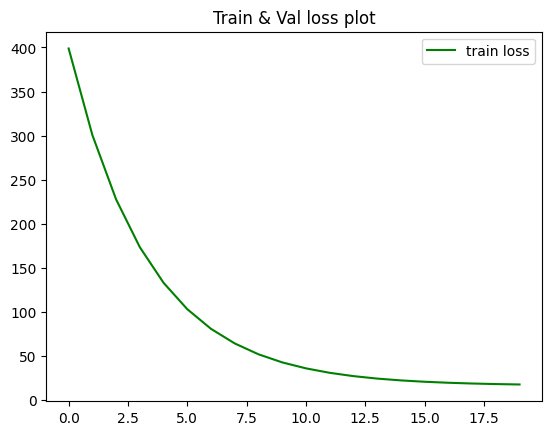

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(training_loss)), [x for x in training_loss], color='green', label='train loss')
# plt.plot(range(len(validation_loss)), validation_loss, color='red', label='val loss')
plt.legend()
plt.title("Train & Val loss plot")
plt.show()

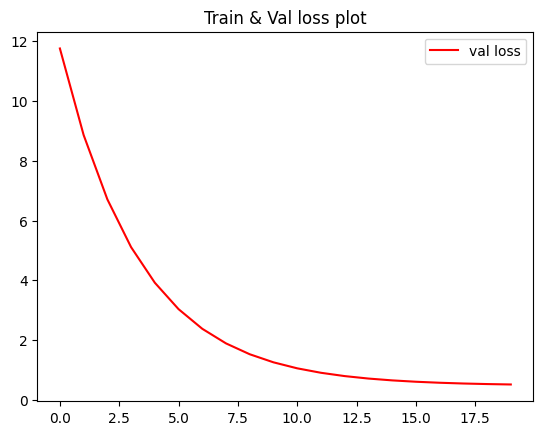

In [ ]:
# plt.plot(range(len(training_loss)), [x for x in training_loss], color='green', label='train loss')
plt.plot(range(len(validation_loss)), validation_loss, color='red', label='val loss')
plt.legend()
plt.title("Train & Val loss plot")
plt.show()

In [ ]:
data.edge_index

tensor([[     0.,      0.,      0.,  ...,  12862.,  12863.,  12863.],
        [ 12864.,  12865.,  12866.,  ..., 112345.,  61681.,   8723.]],
       device='cuda:0', dtype=torch.float64)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
def rmse(model, data):
  true_val = data.val_y
  pred_val = model.predict_proba(data, data.val_mask).detach()
  rmse = mean_squared_error(true_val.cpu(), pred_val.cpu().numpy(), squared=False)
  return rmse
def r_2(model, data):
  true_val = data.val_y
  pred_val = model.predict_proba(data, data.val_mask).detach()
  print(true_val)
  print(pred_val)
  rmse = r2_score(true_val.cpu(), pred_val.cpu().numpy())
  return rmse

In [ ]:
rmse(gcn_model, data)

1.1450208

In [ ]:
r_2(gcn_model, data)

tensor([-1.0000,  0.7211, -1.0000,  ..., -1.0000, -1.0000,  0.8075],
       device='cuda:0')
tensor([-0.1245, -0.1193, -0.1208,  ..., -0.1344, -0.1208, -0.1167],
       device='cuda:0')


0.00286653184081187

In [ ]:
regression_model = RegressionModel()

In [ ]:
model = Model(encoder_model, graph_model, regression_model)

In [ ]:
model.setup(encoder_loader)

In [ ]:
model.train()